# Model evaluation with Cross Validation

Model testing with cross validation suggests a Random Forest Regressor with a buffer size of 500m is the best performing.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import io
from PIL import Image

from Functions import *

## Define random forest model pipeline
(This was found to be best model)

In [2]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

## Produce data in the correct format for the CV process
Store the date time colums to allow segregation of the results by date and time later in the script

In [3]:
buffer_size_m=400
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [4]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Remove year

In [ ]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [7]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [8]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

In [9]:
#### Run cross_val_predict to get predictions
start = time()
predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=cv_parameters)
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

Ran cross_val_predict in 167 minutes


In [373]:
# Convert to a dataframe
predictions_df=pd.DataFrame(predictions)
# Store the predictions
predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   

In [372]:
predictions = pd.read_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m))["0"]

### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

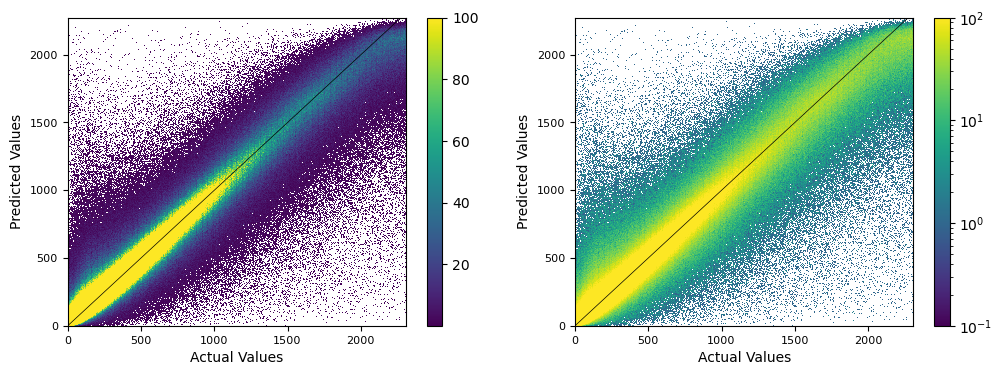

In [11]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

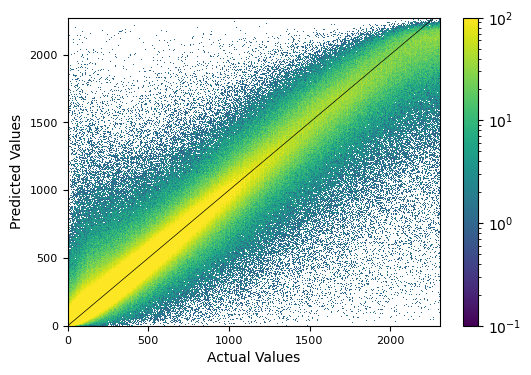

In [28]:
fig, ax = plt.subplots(ncols=1, figsize = (6,4))
# Plot with log scale
using_datashader(ax, Yfull, predictions, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
ax.tick_params(axis='both', which='major', labelsize=8)
fig.savefig("Results/Figs/ModelEvaluation_withCV/ActualVsPredictedValues_log.PNG")
plt.show()

## Find the error in the predictions broken down by hour and sensor

In [276]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions),
                 'Error':Yfull-predictions, 'datetime':data_time_columns['datetime']})
# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

df['Percentage_Difference']= abs(df['Real_vals'] - df['Predictions'])/((df['Real_vals'] + df['Predictions'])/2)* 100
df['Percentage_Increase']= ((df['Real_vals'] - df['Predictions']) / abs(df['Predictions'])) * 100

In [283]:
df["datetime"]  = pd.to_datetime(df["datetime"] , errors='coerce')

In [13]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))
    
# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour of week

In [14]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

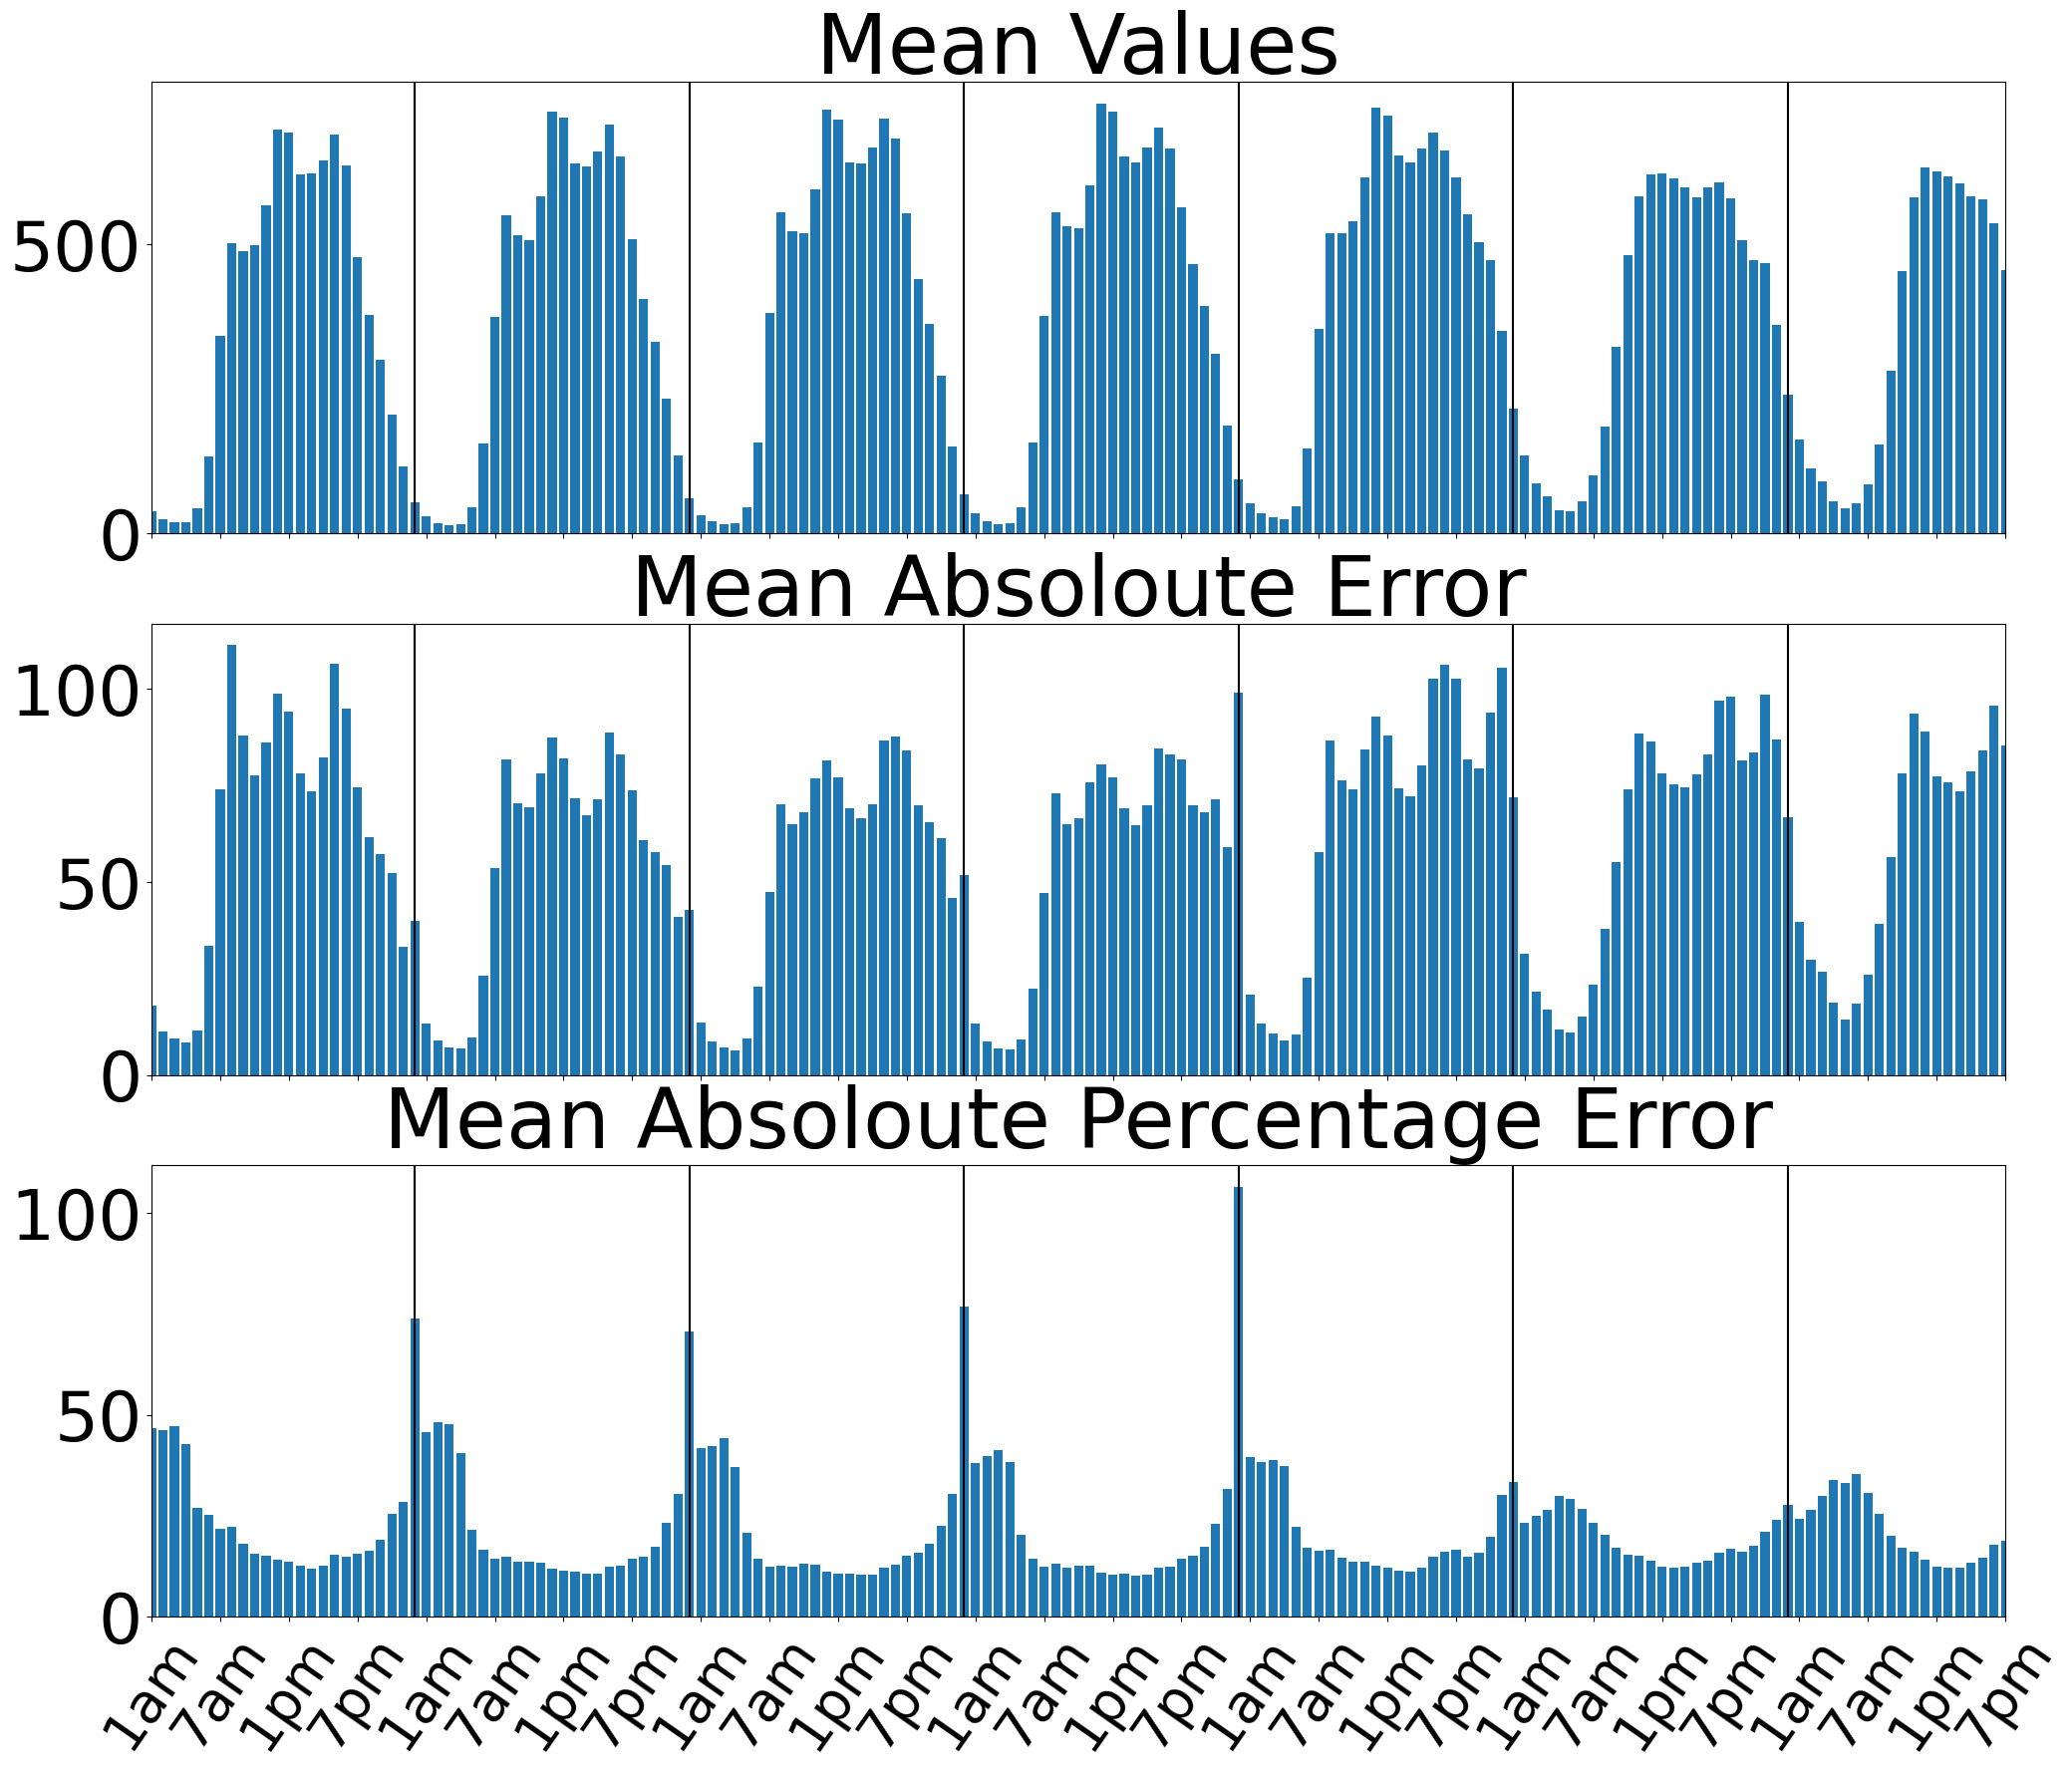

In [29]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6], fontsize=40)
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    
fig.savefig('Results/Figs/ModelEvaluation_withCV/Error_by_hour_of_week.pdf')
fig.savefig('Results/Figs/ModelEvaluation_withCV/Error_by_hour_of_week.jpg')

### Plot errors by hour of day

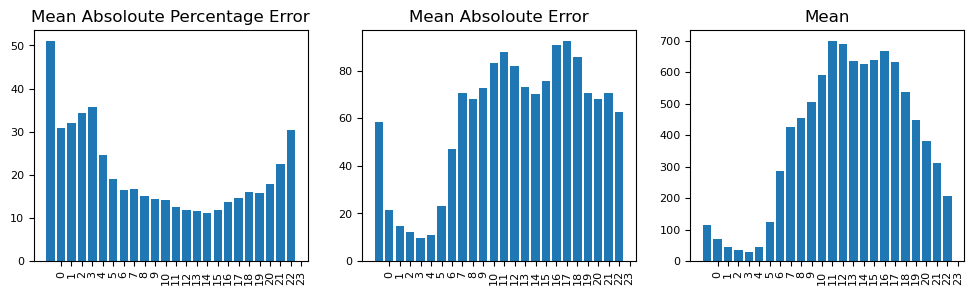

In [16]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

axs[2].tick_params(axis='y', which='major', labelsize=8)
axs[0].tick_params(axis='y', which='major', labelsize=8)
axs[1].tick_params(axis='y', which='major', labelsize=8)

### Plot the errors by sensor

In [17]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [18]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

### MEAN

In [19]:
linear = cm.linear.viridis.scale(melbourne_sensors['Mean'].min(),melbourne_sensors['Mean'].max()).to_step(7)
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_mean.png')

melbourne_map

### MAPE

In [22]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAPE'].min(),melbourne_sensors['MAPE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)


img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAPE.png')
melbourne_map

### MAE

In [23]:
# linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAE'].min(),melbourne_sensors['MAE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map

# Evaluate success of events

## Get data for just one day (e.g. Anzac Day 2015)

In [319]:
anzac_day = df[df['datetime'].dt.strftime('%Y-%m-%d') == '2015-04-25']
anzac_day.head()

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Difference,Percentage_Increase
813607,172.20,63,0,6,23,109.20,-109.20,2015-04-25,w6_h0,92.857143,-63.414634
813608,632.32,483,0,6,20,149.32,-149.32,2015-04-25,w6_h0,26.776172,-23.614626
813609,51.26,17,0,6,11,34.26,-34.26,2015-04-25,w6_h0,100.380897,-66.835739
813610,339.35,184,0,6,2,155.35,-155.35,2015-04-25,w6_h0,59.367536,-45.778695
813611,72.06,50,0,6,43,22.06,-22.06,2015-04-25,w6_h0,36.146158,-30.613378


### Aggregate data by hour (sum or mean)
(and remove unneeded columns)

In [351]:
# del anzac_day['hour_of_week']
# del anzac_day['Weekday']
anzac_day_hourly_values =anzac_day.groupby(['Hour']).sum() #mean()
anzac_day_hourly_values.head()

,Predictions,Real_vals,sensor_id,AbsolouteError,Error,Percentage_Difference,Percentage_Increase
Hour,,,,,,,
0,446.094737,303.210526,21.789474,150.800000,-142.884211,55.095375,-40.143968
1,167.620526,170.526316,21.789474,27.305789,2.905789,25.393494,-2.257119
2,106.802105,125.973684,21.789474,27.101579,19.171579,29.749591,10.439089
3,89.638947,135.263158,21.789474,59.303158,45.624211,47.232304,55.992440
4,64.384595,162.837838,21.594595,100.885676,98.453243,67.364927,165.450479


### Find the errors for each hour 

In [352]:
anzac_day_hourly_values['AbsolouteError'] = abs(anzac_day_hourly_values['Real_vals']-anzac_day_hourly_values['Predictions'])
anzac_day_hourly_values['Error'] = anzac_day_hourly_values['Real_vals']-anzac_day_hourly_values['Predictions']
anzac_day_hourly_values['Percentage_Difference']= abs(anzac_day_hourly_values['Real_vals'] - anzac_day_hourly_values['Predictions'])/((anzac_day_sensorly_values['Real_vals'] + anzac_day_sensorly_values['Predictions'])/2)* 100
anzac_day_hourly_values['Percentage_Increase'] = ((anzac_day_hourly_values['Real_vals'] - anzac_day_hourly_values['Predictions']) / abs(anzac_day_sensorly_values['Predictions'])) * 100

### Plot the trajectory of the real values and the errors throughout the day
(Problem is that if the change on this day is concentrated at particular sensors then this might be hidden within)

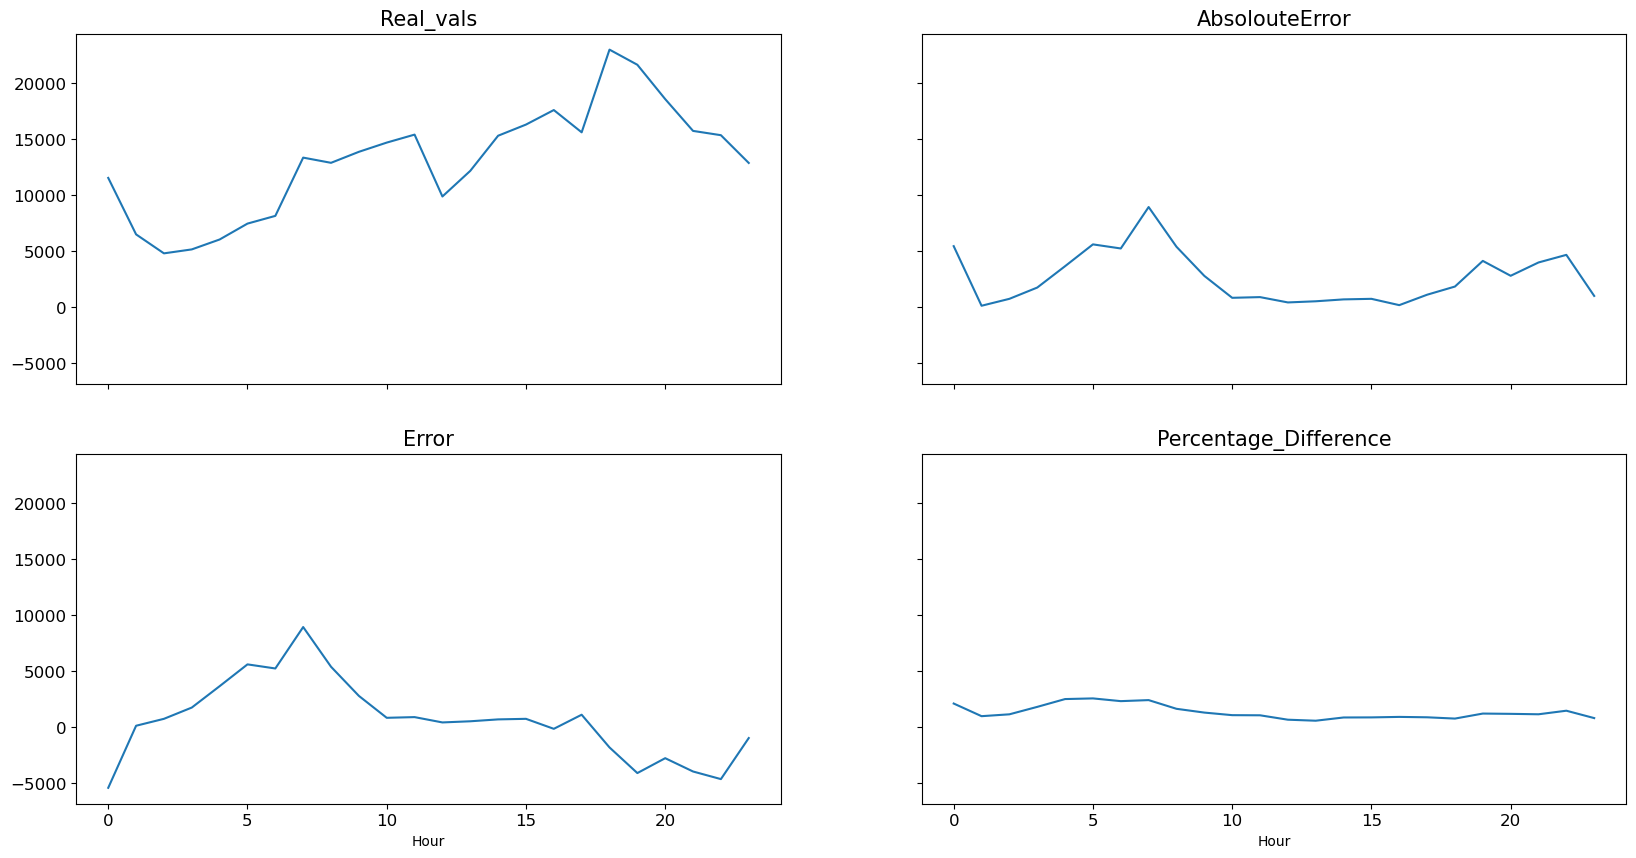

In [350]:
values_to_plot = ['Real_vals', 'AbsolouteError', 'Error', 'Percentage_Difference']

def plot_values (ax, value_to_plot):
    anzac_day_hourly_values[value_to_plot].plot(ax=ax)
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (20,10), sharex = True, sharey = True)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_values(ax, values_to_plot[number])
    ax.xaxis.set_tick_params(labelsize='large')
    ax.yaxis.set_tick_params(labelsize='large')
    ax.set_title(values_to_plot[number], fontsize = 15)

### Aggregate data by sensor (sum or mean)

In [358]:
anzac_day_sensorly_values =anzac_day.groupby(['sensor_id']).sum()

### Find the errors for each sensors 

In [359]:
anzac_day_sensorly_values['AbsolouteError'] = abs(anzac_day_sensorly_values['Real_vals']-anzac_day_sensorly_values['Predictions'])
anzac_day_sensorly_values['Error'] = anzac_day_sensorly_values['Real_vals']-anzac_day_sensorly_values['Predictions']
anzac_day_sensorly_values['Percentage_Difference']= abs(anzac_day_sensorly_values['Real_vals'] - anzac_day_sensorly_values['Predictions'])/((anzac_day_sensorly_values['Real_vals'] + anzac_day_sensorly_values['Predictions'])/2)* 100
anzac_day_sensorly_values['Percentage_Increase'] = ((anzac_day_sensorly_values['Real_vals'] - anzac_day_sensorly_values['Predictions']) / abs(anzac_day_sensorly_values['Predictions'])) * 100

### Join back with sensor geographic data

In [363]:
# anzac_day_sensorly_values = pd.merge(anzac_day_sensorly_values, melbourne_sensors[['Latitude', 'Longitude', 'sensor_id']], on='sensor_id', how='left')
anzac_day_sensorly_values = anzac_day_sensorly_values.sort_values(by='Percentage_Difference',ascending=False)
anzac_day_sensorly_values.head()

,sensor_id,Predictions,Real_vals,Hour,AbsolouteError,Error,Percentage_Difference,Percentage_Increase,Latitude,Longitude
25,29,4634.72,10584,204,5949.28,5949.28,78.183711,128.363310,-37.819658,144.968635
11,12,4062.71,2127,276,1935.71,-1935.71,62.546064,-47.645783,-37.814580,144.942924
32,38,5365.64,9074,21,3708.36,3708.36,51.363607,69.113097,-37.817234,144.967150
10,11,1456.29,889,276,567.29,-567.29,48.376960,-38.954466,-37.815650,144.939707
23,27,3725.54,2307,276,1418.54,-1418.54,47.029609,-38.076091,-37.806069,144.956447


### Plot spatially the errors

In [364]:
error_metric = 'Percentage_Increase'
linear = cm.linear.viridis.scale(anzac_day_sensorly_values[error_metric].min(),anzac_day_sensorly_values[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in anzac_day_sensorly_values.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map

### Plot the hourly values for sensor 29 (which has the biggest change in overall values on this day)
Or 12 or 38 (next 2 biggest)

In [371]:
anzac_day_sensor_29 = anzac_day[anzac_day['sensor_id']==38]
anzac_day_sensor_29.sort_values(by='Percentage_Increase', ascending = False)

,Predictions,Real_vals,Hour,sensor_id,AbsolouteError,Error,datetime,Percentage_Difference,Percentage_Increase
813821,369.01,1685,5,38,1315.99,1315.99,2015-04-25,128.138617,356.627192
813763,429.50,1415,4,38,985.50,985.50,2015-04-25,106.858227,229.452852
813864,404.46,1233,6,38,828.54,828.54,2015-04-25,101.198197,204.850912
813746,537.00,964,3,38,427.00,427.00,2015-04-25,56.895403,79.515829
813638,1897.60,2048,0,38,150.40,150.40,2015-04-25,7.623682,7.925801
813704,680.38,704,2,38,23.62,23.62,2015-04-25,3.412358,3.471589
813662,1047.69,1025,1,38,22.69,-22.69,2015-04-25,2.189425,-2.165717


In [180]:
over_0 = df[df['Real_vals']>0]
over_0 = over_0[over_0['Predictions']>0]
over_0.nlargest(100, 'PercentageIncrease')
df.nlargest(100, 'PercentageIncrease')

,Predictions,Real_vals,Hour,Weekday,Sensor_id,AbsolouteError,Error,hour_of_week,Percentage_Difference,PercentageIncrease
2887987,0.00,1,3,1,67,1.00,1.00,w1_h3,200.000000,inf
3411548,0.00,1,2,2,78,1.00,1.00,w2_h2,200.000000,inf
3228366,0.00,2,4,2,69,2.00,2.00,w2_h4,200.000000,inf
2774577,0.00,1,20,2,59,1.00,1.00,w2_h20,200.000000,inf
2774787,0.00,2,23,2,59,2.00,2.00,w2_h23,200.000000,inf
...,...,...,...,...,...,...,...,...,...,...
2652044,0.02,1,23,5,59,0.98,0.98,w5_h23,192.156863,4900.000000
2702698,0.02,1,20,7,59,0.98,0.98,w7_h20,192.156863,4900.000000
1842523,1.34,66,4,6,46,64.66,64.66,w6_h4,192.040392,4825.373134
2880704,1.10,54,3,3,20,52.90,52.90,w3_h3,192.014519,4809.090909


In [204]:
# total_predicted = df_filtered['Predictions'].sum()
# total_reality = df_filtered['Real_vals'].sum()
# total_predicted

324676.19

### Plot the difference for this date spatially

In [235]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [236]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

In [230]:
sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df_filtered[df_filtered['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

In [242]:
error_metric = 'MAE'
linear = cm.linear.viridis.scale(melbourne_sensors[error_metric].min(),melbourne_sensors[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map

In [243]:
error_metric = 'MAPE'
linear = cm.linear.viridis.scale(melbourne_sensors[error_metric].min(),melbourne_sensors[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map